# Machine Translation (mostly) from Scratch using `PyTorch`

###### Peter Nadel (primary author), Kyle Monahan, Joseph Robertson

In this workshop, we'll build a machine translator using the neural net framework, `PyTorch`. We will implement the transformer architecture to translate between French and English. We'll then see an example using another dataset.

Adapted from: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

To make things run a bit faster, go to Runtime > Change runtime Type and select GPU under Hardware Accelerator.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

For this example, we'll use the `eng-fra.txt` from the `data.zip` file linked from the `PyTorch` page. This file, and all of those which we will look at in this notebook, will be arranged in the following way:

`sentence_i in lang1\tsentence_i in lang2\n`.

It should be noted that this is where this file comes from: https://www.manythings.org/anki/. There are several other languages here, all with varying corpus sizes. I assume the `PyTorch` folks chose French/English translation because of the size of the corpus (~14000 aligned sentences). Later in the notebook, I'll switch out this large aligned corpus with one of the smaller corpuses to anticipate working with Dakota.

In [ ]:
!wget 'https://tufts.box.com/shared/static/v5370zthsaiy5m5xqptv9clsndgyyx1i.zip'
!mv v5370zthsaiy5m5xqptv9clsndgyyx1i.zip data.zip

--2023-03-27 18:04:20--  https://tufts.box.com/shared/static/v5370zthsaiy5m5xqptv9clsndgyyx1i.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/v5370zthsaiy5m5xqptv9clsndgyyx1i.zip [following]
--2023-03-27 18:04:21--  https://tufts.box.com/public/static/v5370zthsaiy5m5xqptv9clsndgyyx1i.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/v5370zthsaiy5m5xqptv9clsndgyyx1i.zip [following]
--2023-03-27 18:04:21--  https://tufts.app.box.com/public/static/v5370zthsaiy5m5xqptv9clsndgyyx1i.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
data_path = 'data/eng-fra.txt'

Before we can dig into this file, we need to make a class that will help us keep track of all of the words in our corpus. In particular, we need this case to do two things:

*   Give each word a unique ID
*   One-hot encode each word at the index of its ID
*   This class will also give us the opportunity to encode our start of sentence (SOS) and end of sentence (EOS) tokens, which we'll place at the beginning and end of each sentence.

Let's start by tracking how many times each word occurs.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        word_list = sentence.replace('\t', ' ').split(' ')
        for word in word_list:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1 # increments on each new word
        else:
            self.word2count[word] += 1 # increments on individual word

In [ ]:
ex_data = open(data_path).readlines()
ex_data[300]

"I'm tidy.\tJe suis ordonnée.\n"

In [ ]:
ex = Lang('ex')
ex.addSentence(ex_data[300])

In [ ]:
ex.word2index

{"I'm": 2, 'ugly.': 3, 'Je': 4, 'suis': 5, 'laid.\n': 6}

In [ ]:
ex.word2count

{"I'm": 1, 'ugly.': 1, 'Je': 1, 'suis': 1, 'laid.\n': 1}

In [ ]:
ex.index2word

{0: 'SOS', 1: 'EOS', 2: "I'm", 3: 'ugly.', 4: 'Je', 5: 'suis', 6: 'laid.\n'}

We have a slight problem here. `I'm` is not a word. Instead, it's two words. In fact, we want our model to be able to understand contractions like this, but we'll first need to strip out all of the punctuation.

Too, because this data is `unicode` encoded, we'll need to convert it to `ASCII`. This step will be especially important when we need to work with languages that do not use the Latin alphabet.

The code below does both.

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
# split up I'm and normalized the text
# we'll turn i m -> i am soon
normalizeString(ex_data[300])

'i m ugly . je suis laid .'

Now we can set up a method to read in the whole file, pair up the aligned sentences and read them into our `Lang` class. We'll keep it as general as possible so we can swap in another dataset later.

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(f'data/{lang1}-{lang2}.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line on the tab character and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs for when we want to go from lang2 to lang1
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

We also want a way to control the size of the sentence that we'll pass into our translator. Right now, we want to train a translator quickly so we'll set it to be small, but we can increase this for a better translator (that will take longer to train).

In [ ]:
MAX_LENGTH = 50

# dealing with most contractions
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full data processing pipeline is as follows:

*   Read text file and split into lines, then split those lines into pairs
*   Normalize each pair and filter by length
*   Make word lists from the sentence pairs

We can stack everything together in the function below.

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 13067 sentence pairs
Counting words...
Counted words:
fra 5171
eng 3389
['je suis tres content de te revoir .', 'i m very glad to see you again .']


## The Seq2Seq Model

**Useful vocabulary for this section**

*   Recurrent Neural Net (RNN) - a network that uses its output sequence as an input for subsequent steps.
*   Seq2Seq network  or Encoder Decoder network - a model consisting of two RNNs: (1) an encoder that reads an input sequence and outputs a vector encoding of the sequence and (2) a decoder that reads the encoded vector and outputs a sequence.
*   Hidden state - a layer of arbitrary size which comes does not come at the beginning or end of the network.
*   [Gated Recurrent Unit (GRU)](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) - a layer of a neural net which consturcts a hidden state at a given time step `t` from the hidden state of time `t-1`. It uses a `tanh` activation and passes all parameters through a sigmoid function.

The Seq2Seq netowrk allows us to input an arbitrarily sized sentence in any language into the encoder and have the vector representation produced by the encoder be decoded into another language by the decoder.

This architecture, though now used in other contexts, is ideal for machine translation. Even though words may come in different orders or are represented by multiple words in a target language, the transformer will be able to render a translation because it is decoding an vector encoded in a multilingual space.

Finally, this architecture is easy(ish) to implement in `PyTorch` as we can first build the encoder and then the decoder then put them together.



### The Encoder

This piece of our Seq2Seq network will be a RNN that outputs some value for every word from the input sentence. For every input word, it will putput a vector and a hidden state, which will be used for the next imput word.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

To break this down a bit:

*   Input is embedded by [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding)
*   Input embedding is activated with [`nn.GRU`](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) and previous hidden state
*   `nn.GRU` outputs an output embedding and another hidden state


### The Decoder

This piece of out Seq2Seq network will be another RNN that take the encoder output (the embedding held by the variable `output` above) and will output a sequence of words that weill constitute the translation. We'll touch on two different type of decoders: a simple decoder and an attention decoder.

#### Simple decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Let's break this down again:

*   Input (output of encoder) is embedded by `nn.Embedding`
*   This embedding is activated by [`F.ReLu`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
*   An output and hidden state are created by passing the activated embedding through `nn.GRU`
*   The hidden state is saved and the output is passed through a softmax layer to create probabilities from the embedding



#### Attention Decoder

**What is attention**

As we see above, the only language data being passed from the encoder to the decoder is the single vector output of `nn.GRU`. *Attention* allows the decoder to pay attention to different parts of the encoder's output. First, we'll calculate *attention weights* with a [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer using the decoder's input and the hidden state as inputs. These will be multiplied by the encoder output to create a combination (called `attn_applied` below) that will contain information about a specific part of the input and then help the decoder to choose the correct output words.

*Note*: There are also other forms of attention, for example 'local attention'.

See here for a diagram: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

We can break this down the same way as with the simple decoder:

*   First, the input is embedded using `nn.Embedding`
*   Then, we pass this input into our attention layer using `nn.Linear` with the input as our x and the previous hidden state as the A in the linear transformation: $y = xA^{T} + b$ (this should look familiar from linear regression)
*   From here, we follow the same steps as in the simple decoder. The attention layer is then combined with the original imput embedding and activated by `F.ReLu`
*   As above, an output and hidden state are created by passing the activated embedding through `nn.GRU`
*   The hidden state is saved and the output is passed through a softmax layer to create probabilities from the embedding

## Training

Now that we understand the architecture of our network, we can begin training. First, we'll need to convert the indices of our sentence pairs into tensors which can be input into our encoder.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token) # appending the EOS token!
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training function

There is one final concept we need to explore before training our Seq2Seq network: *Teacher forcing*. Teacher forcing is when we use the true target outputs (in this case, the correct English language indices) as the each next input, instead of using the decoder's guess for that input. This allows the network to converge faster but can be abused if the dataset is not robust enough. We see that teacher-forced networks have much better understanding of grammar rules, but can stray from the correct translation easier. In fact, it has learned to represent the output grammar well, but not how to create the translation.

`PyTorch` lets us implement teacher forcing with a simple `if` statement. Too, we can use `teacher_forcing_ratio` to control how much teacher forcing we want to use.

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden() # initalized the encoder

    # zeroes encoder/decoder gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input tensors from `tensorsFromPair`
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # encoder forward pass
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # add SOS token to beginning of decoder input
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # decoder forward pass
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # backward pass for whole Seq2Seq network
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
# utilities for timing

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
# utilities for plotting

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
# evaluation will do a foward pass in each RNN and return the words which are most likely
# to be the translation of the input sentence as determined by softmax probabilities

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training will proceed as follows:

*   Start the timer
*   Initialize optimizers and loss function
*   Create training batch
*   Record loss for plotting
*   Evaluate our model



In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Training results

1m 25s (- 20m 1s) (5000 6%) 3.0698
2m 48s (- 18m 12s) (10000 13%) 2.5384
4m 14s (- 16m 57s) (15000 20%) 2.2402
5m 38s (- 15m 31s) (20000 26%) 1.9931
7m 6s (- 14m 12s) (25000 33%) 1.8022
8m 29s (- 12m 44s) (30000 40%) 1.6516
9m 53s (- 11m 18s) (35000 46%) 1.5201
11m 17s (- 9m 52s) (40000 53%) 1.4076
12m 41s (- 8m 27s) (45000 60%) 1.2953
14m 4s (- 7m 2s) (50000 66%) 1.1893
15m 28s (- 5m 37s) (55000 73%) 1.0975
16m 53s (- 4m 13s) (60000 80%) 1.0386
18m 18s (- 2m 48s) (65000 86%) 0.9832
19m 42s (- 1m 24s) (70000 93%) 0.9107
21m 6s (- 0m 0s) (75000 100%) 0.8556


<Figure size 432x288 with 0 Axes>

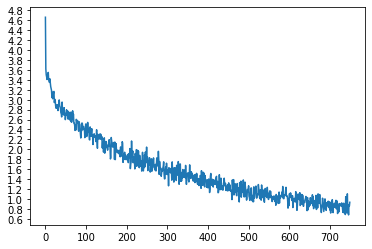

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> tu es son frere n est ce pas ?
= you are his brother right ?
< you are not ready with ? <EOS>

> je suis promue .
= i m being promoted .
< i m being . <EOS>

> soit il est saoul soit il est fou .
= he is either drunk or mad .
< he is crazy my my . . <EOS>

> vous n etes pas fatigues si ?
= you re not tired are you ?
< you re not upset are you ? <EOS>

> il a probablement tort .
= he s probably wrong .
< he s probably wrong . <EOS>

> je vais bientot etre partie .
= i m going to be gone soon .
< i m going to be in big trouble . <EOS>

> je suis puissant .
= i m powerful .
< i m powerful . <EOS>

> vous etes degoutantes .
= you re disgusting .
< you re disgusting . <EOS>

> je n ai pas l intention de preparer a diner pour vingt personnes .
= i m not willing to cook dinner for twenty people .
< i m not willing to stay dinner . . <EOS>

> tu es la femme la plus belle du monde .
= you re the most beautiful woman in the whole world .
< you re the most beautiful woman in the world . <EOS>



## Trying a new dataset

As I mentioned above, now that we have implemented the transformer architecture, we can now try on a new dataset, one that is comparable in size to the forthcoming Dakota dataset. In this example, I'll use [Breton](https://en.wikipedia.org/wiki/Breton_language), the language spoken by people living in Brittany, currently a part of France but was at one point a sovereign nation with its own language. Breton is one of the few remaining Celtic languages, the speakers of which, similar to the native Americans of this continent thousands of years later, were murdered and forcibly assimilated into Roman society during the conquests of Julius Caesar. Though speakers of Breton are few, they are tenacious.


In [ ]:
!unzip bre-eng.zip

unzip:  cannot find or open bre-eng.zip, bre-eng.zip.zip or bre-eng.zip.ZIP.


In [ ]:
# there's some extra cleaning we need to do to make it look like the eng-fre dataset...
!head bre.txt

head: cannot open 'bre.txt' for reading: No such file or directory


In [ ]:
# making a new file which we can pass into the data prep process
raw = open('bre.txt').readlines()
clean = [re.sub('(?=\tCC).*','', r) for r in raw]
clean[:10]

['Thanks!\tTrugarez !\n',
 'Thanks!\tMersi !\n',
 'Thanks!\tBennozh !\n',
 'Thanks.\tTrugarez.\n',
 'Thanks.\tMersi.\n',
 'Thanks.\tBennozh.\n',
 'I eat bread.\tBara a vez debret ganin.\n',
 'Many thanks.\tMil drugarez.\n',
 'Many thanks.\tMil bennozh.\n',
 'Are you here?\tAmañ emaout ?\n']

In [ ]:
with open('eng-bre.txt', 'w') as f:
    for c in clean:
        f.write(c)

In [ ]:
!head eng-bre.txt

Thanks!	Trugarez !
Thanks!	Mersi !
Thanks!	Bennozh !
Thanks.	Trugarez.
Thanks.	Mersi.
Thanks.	Bennozh.
I eat bread.	Bara a vez debret ganin.
Many thanks.	Mil drugarez.
Many thanks.	Mil bennozh.
Are you here?	Amañ emaout ?


In [ ]:
# just need to move this file into the data directory
!cp eng-bre.txt data

In [ ]:
MAX_LENGTH = 50

def prepareData(lang1, lang2, trim=True, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    if trim:
        pairs = filterPairs(pairs)
        print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'bre', False, True)
print(random.choice(pairs))

Reading lines...
Read 196 sentence pairs
Counting words...
Counted words:
bre 306
eng 208
['dav din mont .', 'i have to leave .']


1m 11s (- 16m 37s) (5000 6%) 1.2052
2m 19s (- 15m 9s) (10000 13%) 0.0472
3m 27s (- 13m 50s) (15000 20%) 0.0152
4m 35s (- 12m 38s) (20000 26%) 0.0090
5m 44s (- 11m 28s) (25000 33%) 0.0057
6m 52s (- 10m 18s) (30000 40%) 0.0049
8m 0s (- 9m 9s) (35000 46%) 0.0043
9m 8s (- 8m 0s) (40000 53%) 0.0040
10m 16s (- 6m 50s) (45000 60%) 0.0037
11m 24s (- 5m 42s) (50000 66%) 0.0030
12m 32s (- 4m 33s) (55000 73%) 0.0033
13m 40s (- 3m 25s) (60000 80%) 0.0028
14m 48s (- 2m 16s) (65000 86%) 0.0028
15m 56s (- 1m 8s) (70000 93%) 0.0028
17m 4s (- 0m 0s) (75000 100%) 0.0024


<Figure size 432x288 with 0 Axes>

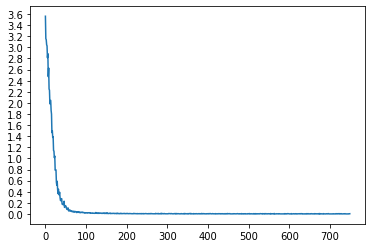

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> ur c harr az peus ?
= do you have a car ?
< do you have a car ? <EOS>

> pegement eo ar montr man ?
= how much is this watch ?
< how much is this watch ? <EOS>

> dont a ran eus tokyo bro japan .
= i m from tokyo japan .
< i m from tokyo japan . <EOS>

> se n eo ket ur frazenn .
= this is not a sentence .
< this is not a sentence . <EOS>

> me a wel un dra bennak .
= i see something .
< i see something . <EOS>

> kelenn a blij din .
= i love teaching .
< i love teaching . <EOS>

> o vervel e oant .
= they were dying .
< they were dying . <EOS>

> n eus abeg ebet da vezan spontet .
= there s no reason to be afraid .
< there s no reason to be afraid . <EOS>

> bez zo ur bern keriou bras e barzh ar brazil .
= there are a lot of big cities in brazil .
< there are a lot of big cities in brazil . <EOS>

> n em eus ket kousket .
= i haven t slept .
< i haven t slept . <EOS>



In [ ]:
# can save our models for later using pickle
import pickle
pickle.dump(encoder1, open("breton_english_encoder.p", "wb" ))
pickle.dump(attn_decoder1, open("breton_english_decoder.p", "wb" ))

# Conclusion

Transformers take advantage of the sequential nature of the textual data which they encode and decode. That said, transformers are able to encode and decode much more than just aligned sentence pairs. In fact, they can be used with any sequential data, which ends up being most data in general. For instance, a system like ChatGPT learns how to answer questions through the same process. The question is encoded by an encoder and then the answer is decoded from that vector space by a decoder. Stable diffusion and other image generation models take in text and encode them and then decode an image.

Too, encoding embeddings can be swapped out with pre-trained word embeddings from word2vec or GloVe. These encoding layers are amazing resources for research and can offer new insights into large datasets across the social sciences and the humanities.